<font size=4 color="08#0000" face="Times New Roman"> The improvement of the Investment Clock Model</font>  

<font size=3 face="Times New Roman">Considering two main drawbacks, failing to forecast and low frequency data, of the original investment clock model,in this section we aim to improve this model with monthly leading economic variable.</font>

In [49]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [105]:
os.chdir("D:\各种材料\研究生\公众号\三、美林时钟模型")
data=pd.read_excel(r"D:\各种材料\研究生\公众号\三、美林时钟模型\模型改进的探索.xlsx")


Indicator_NA=pd.concat([data["日期"],data["PPI:当月同比"],data["CPI-PPI"]],axis=1)#将原始数据集保留
Indicator=Indicator_NA.dropna(0)
Indicator_date=Indicator["日期"] #记录原始日期
Indicator["日期"]=Indicator_date.map(lambda a : a.strftime('%Y-%m'))
Indicator.index=Indicator["日期"]
del Indicator["日期"]
Indicator.head()

D:\Software Download\Ananconda\anaconda\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,PPI:当月同比,CPI-PPI
日期,,
1996-10,0.34,6.66
1996-11,0.04,6.86
1996-12,0.43,6.57
1997-01,0.12,5.78
1997-02,0.44,5.16


In [106]:
price=pd.read_excel("D:\各种材料\研究生\公众号\三、美林时钟模型\资产价格.xlsx","中国2")
price=price.dropna(0)
price_date=price["日期"]
price.index=price_date.map(lambda a : a.strftime('%Y-%m'))
del price["日期"]
price.head()

,沪深300,中债-新综合净价(总值)指数,南华商品指数,3个月中国国债收益率
日期,,,,
2004-06,1078.485,96.2277,1007.1169,2.9654
2004-07,1088.677,96.5451,965.7056,2.5423
2004-08,1055.970,96.3873,979.0981,2.7620
2004-09,1109.324,96.0118,996.9959,2.7135
2004-10,1050.299,95.9732,958.4566,3.0929


<font size=4 face="Times New Roman" color="08#0000">回测</font>

In [108]:
def Investment_Clock_Improvement(Indicator,price, lag_e,lag_i,method_e,method_i):
    #The function is to identify the circle in American Investment Clock Model
    #D is DataFrame,lag_e is the lag term of the ecomony indicator is the lag term, method={"Directly","Average"}
    name=Indicator.columns
    name_i=name[0]####????会有问题，一定要通胀在前，经济在后
    name_e=name[1]
    L=len(Indicator)
    pos0=max(lag_e,lag_i)#最大滞后项。
    
    R=[]#储存月收益率
    start_month=[]#储存起始月份
    end_month=[]#储存种植月份
    Asset_Order=[]#储存每期资产排名
    Asset_Select=[]#储存每期资产
    RightOrWrong=[]#是否选择了收益率为正的资产
    circle_type=[]#记录周期类型
    Asset_Rank=[]#记录所选择资产的排名
    
    for i in range(pos0,L-1):
        month_beg=Indicator.index[i]
        if month_beg not in price.index: #Indicator中的日期在
            continue
            
        if method_e=="Directly":
            trend_e=np.sign(Indicator.iloc[i][name_e]-Indicator.iloc[i-lag_e][name_e])
        else:
            trend_e=np.sign(Indicator.iloc[i][name_e]-Indicator.iloc[i-lag_e:i][name_e].mean())
            
        if method_i=="Directly":
            trend_i= np.sign(Indicator.iloc[i][name_i]-Indicator.iloc[i-lag_i][name_i])
        else:
            trend_i= np.sign(Indicator.iloc[i][name_i]-Indicator.iloc[i-lag_i:i][name_i].mean())        
        
        
        #判断资产的选择类型
        if (trend_e==1) and (trend_i==-1):#复苏
            asset='沪深300'
            circle=0
        elif (trend_e==1) and (trend_i==1):#过热
            asset='南华商品指数'
            circle=1
        elif (trend_e==-1) and (trend_i==-1):#衰退
            asset='中债-新综合净价(总值)指数'
            circle=3
        else:
            asset='3个月中国国债收益率' #滞胀
            circle=2
            
        month_beg=Indicator.index[i]
        month_end=Indicator.index[i+1]
        result_monthly=month_return(price,asset,month_beg,month_end)
        
        #插入到已知列表
        month_r=result_monthly[0]
        order=result_monthly[1]
        rank=result_monthly[2]
        PosOrNeg=result_monthly[3]
        
        R.append(month_r)
        start_month.append(Indicator.index[i])
        end_month.append(Indicator.index[i+1])
        circle_type.append(circle)
        Asset_Order.append(order)
        Asset_Select.append(asset)
        RightOrWrong.append(PosOrNeg)
        Asset_Rank.append(rank)
        
        output=[start_month, end_month, Asset_Order,circle_type,Asset_Select,R,Asset_Rank,RightOrWrong]
        
    return output

In [109]:
def month_return(price,asset,month_beg,month_end):
    if month_end in price.index:
        r=price.loc[month_end]/price.loc[month_beg]-1
        r["3个月中国国债收益率"]=(price.loc[month_end]["3个月中国国债收益率"]-price.loc[month_beg]["3个月中国国债收益率"])/100
        month_r=r[asset]
        r_sort=r.sort_values(ascending=False)#收益率排序
        order=list(r_sort.index)#按收益率从高到低的资产名称
        rank=order.index(asset)+1#得到4类资产中的排名
        if r[asset]>0:
            PosOrNeg=1 #即选中了收益率大于零的资产
        else:
            PosOrNeg=0  
        res=[month_r,order,rank,PosOrNeg]
    else:
        res=[np.nan,[np.nan,np.nan,np.nan,np.nan],np.nan,np.nan]
    return res

<font color="08#0000" size=4 face="Times New Roman">净值及风险指标计算</font>

In [110]:
import math
def res_output(Indicator, price,lag_e,lag_i, method_e,method_i):
    res=Investment_Clock_Improvement(Indicator,price,lag_e,lag_i,method_e,method_i)
    #计算净值
    r=res[5]
    r_plus1=np.array(r)+1
    nav=np.cumprod(r_plus1)
    nav=pd.DataFrame(nav,index=res[1],columns=['净值'])
    start_date=res[0][0]
    nav.loc[start_date]=1
    nav=nav.sort_index()
    plt.plot(nav)
    
    #计算风险值指标
    whole_return=nav.values
    annual_return=(whole_return[-1][0])**(12/len(whole_return))-1
    annual_vol=r_plus1.std()*math.sqrt(12)
    sharp=annual_return/annual_vol
    return_list=whole_return
    max_turndown=((np.maximum.accumulate(return_list) - return_list) / np.maximum.accumulate(return_list)).max()
    calmar=annual_return/max_turndown
    
    #数据保存
    filename="Clock中国改进回测"+method_e+str(lag_e)+method_i+str(lag_i)+" .xlsx"
    writer=pd.ExcelWriter(filename)
    nav.to_excel(writer,'净值',float_format='%.5f')
    #回测过程具体信息
    end_month=pd.DataFrame(res[1],index=res[0],columns=['终止日期'])
    assetorder=pd.DataFrame(res[2],index=res[0],columns=['1st','2nd','3rd','4th'])
    circle_type=pd.DataFrame(res[3],index=res[0],columns=['周期类型'])
    assetselect=pd.DataFrame(res[4],index=res[0],columns=['所选资产'])
    R=pd.DataFrame(res[5],index=res[0],columns=['所选资产月收益率'])
    SelectRank=pd.DataFrame(res[6],index=res[0],columns=['所选资产排名'])
    RightOrWrong=pd.DataFrame(res[7],index=res[0],columns=['所选资产收益率是否为正'])
    res=pd.concat([end_month,assetorder,circle_type,assetselect,R,SelectRank,RightOrWrong],axis=1)
    res.to_excel(writer,'回测过程',float_format='%.5f')
    
    #风险指标信息
    valuation_factor=np.array([annual_return, annual_vol,sharp,max_turndown, calmar])
    Valuation=pd.DataFrame(valuation_factor,columns=["风险评价指标"],index=['年化收益率','年化波动率','夏普比例','最大回撤','Calmar'])
    Valuation.to_excel(writer,'风险评价指标',float_format='%.5f')
    writer.save()
    return  valuation_factor

array([0.19420266, 0.22788297, 0.85220349, 0.36802121, 0.52769421])

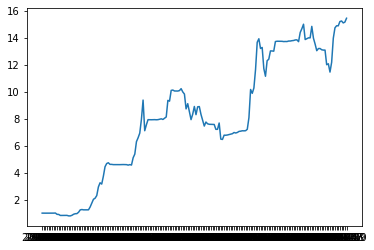

In [143]:
#Investment_Clock_Improvement(Indicator,price, lag_e,lag_i,method_e,method_i):
Valuation=res_output(Indicator, price,4,3, 'Directly','Directly')
Valuation